# Lecture 19: Introduction to Computer Vision

CSCI 1360E: Foundations for Informatics and Analytics

## Overview and Objectives

In this lecture, we'll touch on some concepts related to image processing and computer vision. By the end of this lecture, you should be able to

 - Read in and display any JPEG or PNG image using Scientific Python (SciPy)
 - Understand core image processing techniques such as thresholding, blurring, and segmentation
 - Recall some of the computer vision packages available in Python for more advanced image processing

## Part 1: Computer Vision

Whenever you hear about or refer to an image analysis task, you've stepped firmly into territory occupied by *computer vision*, or the field of research associated with understanding images and designing algorithms to do the same.

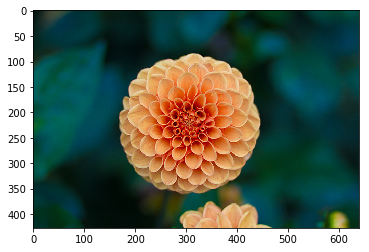

In [1]:
%matplotlib inline
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

img = load_sample_image("flower.jpg")
plt.imshow(img)

### Examples of Computer Vision

You can probably name numerous examples of computer vision already, but just to highlight a couple:

![fbook](Lecture19/Facebook-facial-recognition-main.jpg)

 - Facebook and Google use sophisticated computer vision methods to perform facial recognition scans of photos that are uploaded to their servers. You've likely seen examples of this when Facebook automatically puts boxes around the faces of people in a picture, and asks if you'd like to tag certain individuals.

![tesla](Lecture19/tesla-model-s-autopilot-sensors.jpg)

 - Tesla Motors' "Autopilot" and other semi-autonomous vehicles use arrays of cameras to capture outside information, then process these photos using computer vision methods in order to pilot the vehicle. Google's experimental self-driving cars use similar techniques, but are fully autonomous.

![oscars](Lecture19/25CCD2F400000578-2958597-image-a-27_1424270103152.jpg)

 - The subarea of machine learning known as "deep learning" has exploded in the last five years, resulting in state-of-the-art image recognition capabilities. Google's DeepMind can recognize arbitrary images to an extraordinary degree, and similar deep learning methods have been used to automatically generate captions for these images.

This is all to underscore: **computer vision is an extremely active area of research and application!**

 - Automated categorization and annotation of YouTube videos (identification of illegal content?)

 - Analyzing photos on your smartphones

 - Law enforcement facial recognition

 - Disabled access to web technologies

 - Virtual reality

### Data Representations

From the perspective of the computer, the simplest representation of an image is a large rectangular array of pixels.

Each pixel has some value that corresponds to a color (or *intensity*). For example, in black and white (or *grayscale*) images, pixels are typically represented by a single integer value.

Full-color images are often represented in RGB (Red-Green-Blue) format, and their data structure consists of three rectangular arrays of pixels, one for each color channel.

![rgbarrays](Lecture19/ch_data_struct5.png)

In this example, representing Red-Green-Blue requires *three* matrices stacked on each other--one for the red values, one for the green, and one for the blue. The number of rows is the height of the image, and the number of columns is the width of the image. 

Both grayscale and RGB image pixels tend to be represented by 8-bit unsigned integers that range from 0 (black) to 255 (white), but can also be represented by floating point values that range from 0 (white) to 1 (black).

There are *many* other image formats and representations, but they tend to be variations on this theme.

### Image Processing

There are lots and lots of ways in which you can process and analyze your images, but in this lecture we'll discuss three methods: *thresholding*, *blurring/sharpening*, and *segmentation*, though these all interrelate with one another.

 - **Thresholding** is the process by which you define a pixel threshold--say, the value 100--and set every pixel *below* that value to 0, and every pixel *above* that value to 255. In doing so, you *binarize* the image.

 - **Blurring** and **sharpening** are self-explanatory: you've probably used these tools in an image editor like Photoshop or GIMP before. Formally, blurring is the process of "averaging" nearby pixels values together, smoothing out hard boundaries. Sharpening does the opposite.

 - **Segmentation** is the process through which you divide your image up into logical pieces. Perhaps you're segmenting out people from the rest of the image to perform facial recognition, or you're segmenting distinct cells from a microscope image.

## Part 2: Loading and Manipulating Images

Let's jump into it and get our hands dirty, shall we? We'll use the flower image we saw before.

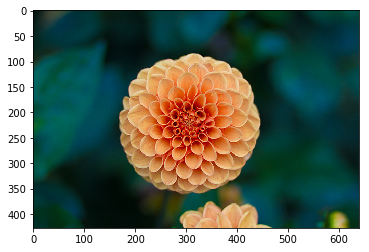

In [2]:
plt.imshow(img)

(recall the `matplotlib` method `imshow` that's useful for visualizing images!)

As with any data, it's good a have a "feel" for what you're dealing with. This is the "data exploration" step, and usually involves computing some basic statistics.

Things like shape, value range, average, median...even the histogram of values (*distribution*!) is useful information.

In [3]:
print("Image dimensions: {}".format(img.shape))

Image dimensions: (427, 640, 3)


Remember our discussion of image formats. Image are basically NumPy arrays, so all the usual NumPy functionality is at your disposal here. Our image is 427 rows by 640 columns (height of 427, width of 640), and is in RGB format (hence the 3 trailing dimensions--one 427x640 block for each of the three colors).

Let's take a look at these three color channels, one at a time.

In [4]:
print("Min/Max of Red: {} / {}".format(img[:, :, 0].min(), img[:, :, 0].max()))
print("Min/Max of Green: {} / {}".format(img[:, :, 1].min(), img[:, :, 1].max()))
print("Min/Max of Blue: {} / {}".format(img[:, :, 2].min(), img[:, :, 2].max()))

Min/Max of Red: 0 / 255
Min/Max of Green: 0 / 229
Min/Max of Blue: 0 / 197


Red seems to have the widest range, from the minimum possible of 0 to the maximum possible of 255. What about average, median, and standard deviation?

In [5]:
import numpy as np  # Need this for computing median.
print("Mean/Median (Stddev) of Red: {:.2f} / {:.2f} (+/- {:.2f})" \
      .format(img[:, :, 0].mean(), np.median(img[:, :, 0]), img[:, :, 0].std()))
print("Mean/Median (Stddev) of Green: {:.2f} / {:.2f} (+/- {:.2f})" \
      .format(img[:, :, 1].mean(), np.median(img[:, :, 1]), img[:, :, 1].std()))
print("Mean/Median (Stddev) of Blue: {:.2f} / {:.2f} (+/- {:.2f})" \
      .format(img[:, :, 2].mean(), np.median(img[:, :, 2]), img[:, :, 2].std()))

Mean/Median (Stddev) of Red: 55.13 / 4.00 (+/- 89.02)
Mean/Median (Stddev) of Green: 73.58 / 61.00 (+/- 45.51)
Mean/Median (Stddev) of Blue: 57.00 / 54.00 (+/- 33.23)


Well, this is certainly interesting. The mean and median for Blue are very similar, but for Red they're *very* different, which suggests some heavy skewing taking place.

Let's go ahead and look at the histograms of each channel, then!

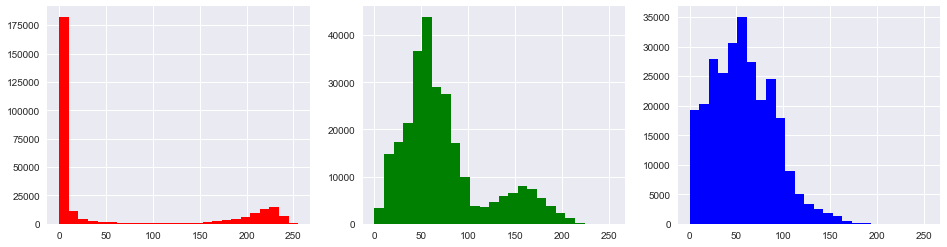

In [6]:
import seaborn as sns
fig = plt.figure(figsize = (16, 4))
plt.subplot(131)
_ = plt.hist(img[:, :, 0].flatten(), bins = 25, range = (0, 255), color = 'r')
plt.subplot(132)
_ = plt.hist(img[:, :, 1].flatten(), bins = 25, range = (0, 255), color = 'g')
plt.subplot(133)
_ = plt.hist(img[:, :, 2].flatten(), bins = 25, range = (0, 255), color = 'b')

Well, this certainly explains a few things! As we can see, the *vast* majority of pixels in the red channel are black! The green and blue channels are a bit more evenly distributed, though even with green we can see a hint of a second peak around the pixel value 150 or so. Hopefully this illustrates why even all these basic statistics can be misleading!

We can even visualize the image using only the pixel values from one channel, one at a time.

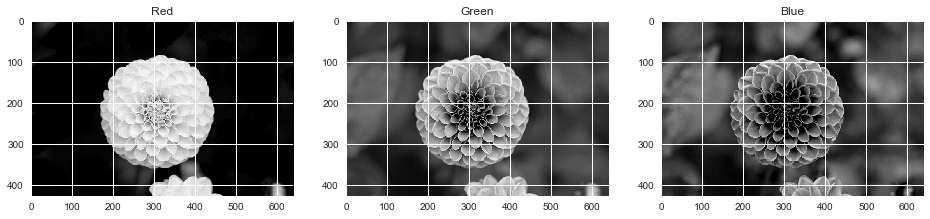

In [7]:
fig = plt.figure(figsize = (16, 4))
plt.subplot(131)
plt.title("Red")
plt.imshow(img[:, :, 0], cmap = "gray")
plt.subplot(132)
plt.title("Green")
plt.imshow(img[:, :, 1], cmap = "gray")
plt.subplot(133)
plt.title("Blue")
plt.imshow(img[:, :, 2], cmap = "gray")

And there you have it. As we can see for ourselves, the red channel tends to be either black (entire background) or pretty bright (the flower), where the green and blue channels are much more evenly spread.

### Thresholding

So how would a threshold work? Let's start just with the green channel, for simplicity. We'll use the median pixel value (61) as the threshold.

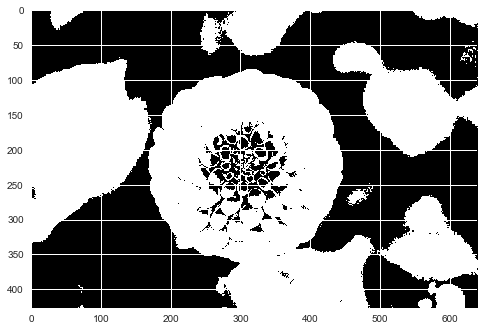

In [8]:
green_channel = img[:, :, 1]  # pull out the green channel, just so we don't have to keep indexing it
binarized = (green_channel > np.median(green_channel))
plt.imshow(binarized, cmap = "gray")

Whether or not this is a "good" binarization is entirely dependent on what your data are and what you're trying to do. But if we were, for example, trying to separate the flower from the background, this would be an ok start--as you can see, a lot of the background was selected along with the flower.

Maybe we could try to use the mean as a threshold? The mean value for the green channel is larger than the median, so it may cut out some of that background.

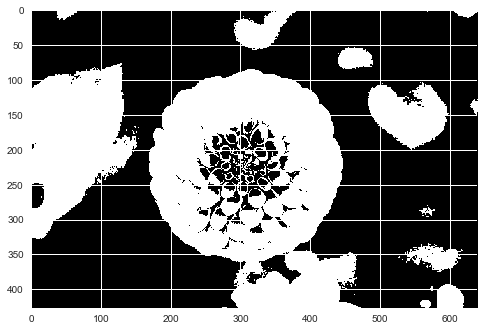

In [9]:
binarized = (green_channel > green_channel.mean())
plt.imshow(binarized, cmap = "gray")

Hey, that's an improvement! Still not perfect--a big blob of white on the far left, and some smaller blobs on the right--but it's definitely a lot clearer than the last binarization!

### Blurring / Sharpening

Maybe we could try blurring the image a little? This has the effect of "averaging" nearby pixels together, effectively smoothing them out. How "big" your filter is governs how large the definition of "nearby" is when averaging pixels together; the bigger your filter, the more pixels are included in the averaging.

For blurring and sharpening, though, we'll need some help...

### `scipy.ndimage`

Scientific Python, or *SciPy*, is an incredible software package that provides a wealth of scientific computing methods, and is pretty much the bedrock of any program you'll create that goes beyond basic averaging.

SciPy has a submodule called `ndimage`, or *n-dimensional image*, which provides a basic interface for image manipulation and analysis. I only say "basic" because you need only look beyond `ndimage` if you're doing cutting-edge computer vision research; for most cases, the functions available in this submodule are more than sufficient.

In [10]:
from scipy import ndimage

Ok! Back to blurring and sharpening.

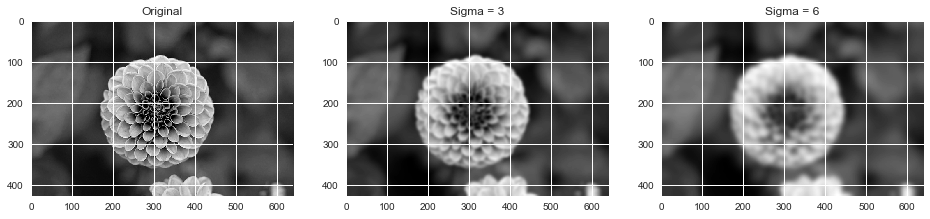

In [11]:
blurred = ndimage.gaussian_filter(green_channel, sigma = 3)
very_blurred = ndimage.gaussian_filter(green_channel, sigma = 6)

fig = plt.figure(figsize = (16, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(green_channel, cmap = "gray")
plt.subplot(132)
plt.title("Sigma = 3")
plt.imshow(blurred, cmap = "gray")
plt.subplot(133)
plt.title("Sigma = 6")
plt.imshow(very_blurred, cmap = "gray")

Now what happens when we threshold the images?

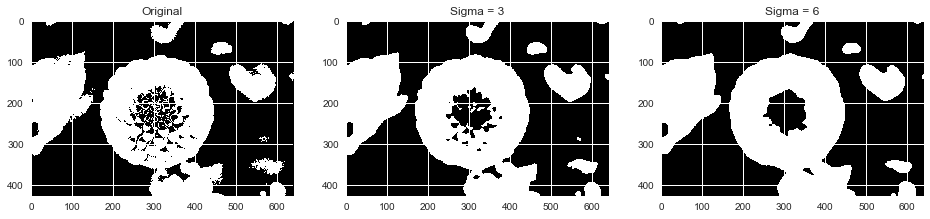

In [12]:
bin_orig = (green_channel > green_channel.mean())
bin_blur = (blurred > blurred.mean())
bin_vblur = (very_blurred > very_blurred.mean())

fig = plt.figure(figsize = (16, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(bin_orig, cmap = "gray")
plt.subplot(132)
plt.title("Sigma = 3")
plt.imshow(bin_blur, cmap = "gray")
plt.subplot(133)
plt.title("Sigma = 6")
plt.imshow(bin_vblur, cmap = "gray")

Blurring seems to have *some* effect--a few of the smaller objects on the right side disappeared entirely for Sigma = 6--but the larger background objects are still there.

We can try sharpening the image--the reverse operation of blurring. We can do this by blurring the blurred image further, and then using the second image to *augment* the original in a way that sharpens it. (I know this sounds confusing, but bear with me)

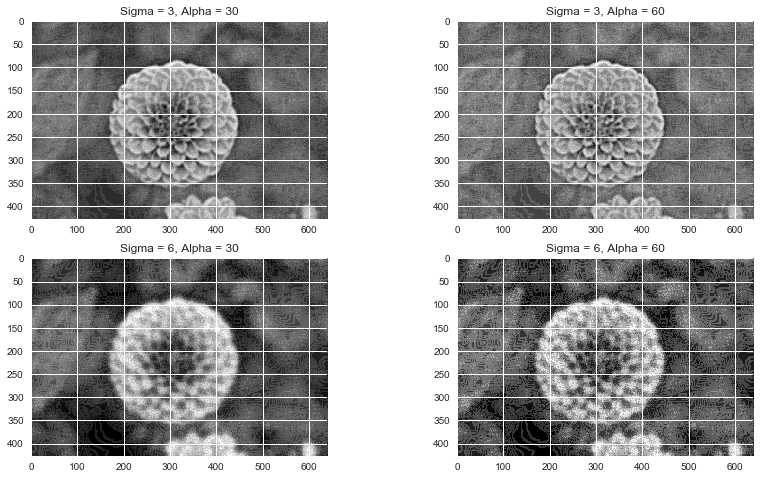

In [13]:
alpha30 = 30  # How sharp we want the image to be.
alpha60 = 60

filter_b = ndimage.gaussian_filter(blurred, sigma = 1).astype(float)
sharp_blur_30 = blurred + alpha30 * (blurred - filter_b)
sharp_blur_60 = blurred + alpha60 * (blurred - filter_b)

filter_v = ndimage.gaussian_filter(very_blurred, sigma = 1).astype(float)
sharp_very_30 = very_blurred + alpha30 * (very_blurred - filter_v)
sharp_very_60 = very_blurred + alpha60 * (very_blurred - filter_v)

fig = plt.figure(figsize = (14, 8))
plt.subplot(221)
plt.title("Sigma = 3, Alpha = 30")
plt.imshow(sharp_blur_30, cmap = "gray")
plt.subplot(222)
plt.title("Sigma = 3, Alpha = 60")
plt.imshow(sharp_blur_60, cmap = "gray")
plt.subplot(223)
plt.title("Sigma = 6, Alpha = 30")
plt.imshow(sharp_very_30, cmap = "gray")
plt.subplot(224)
plt.title("Sigma = 6, Alpha = 60")
plt.imshow(sharp_very_60, cmap = "gray")

Still not quite the effect we're looking for. Still, we've got one more trick up our sleeve, courtesy of `ndimage`.

### Segmentation

The function **`ndimage.label()`** takes a binary image as input, and finds all the *connected components* in the image.

Connected components are contiguous blocks of pixels with the value "1". The function finds these blocks and assigns each one a unique ID, thereby picking out all the "objects" in the image.

![labeling](Lecture19/Sample.png)

Let's give that a shot, using our *blurred* image, with Sigma = 3.

Found 17 objects.


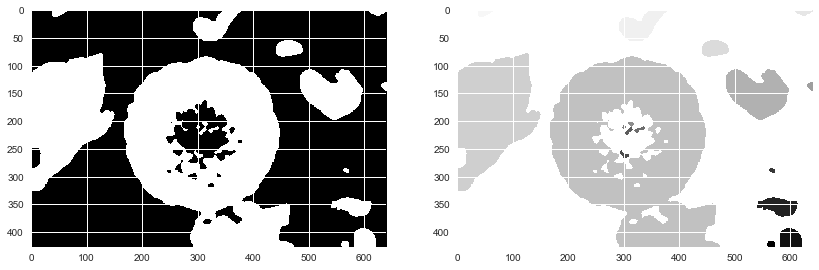

In [14]:
binarized = (blurred > blurred.mean())
labels, num_labels = ndimage.label(binarized)
print("Found {} objects.".format(num_labels))

fig = plt.figure(figsize = (14, 8))
plt.subplot(121)
plt.imshow(binarized, cmap = "gray")
plt.subplot(122)
plt.imshow(labels)

Ok, we found 17 objects--contiguous blocks of pixels with the value "1" that are all connected to each other--now what can we do to pick out the flower from the other objects?

We can compute the sizes of each of the objects. Perhaps we could throw out everything except the largest object?

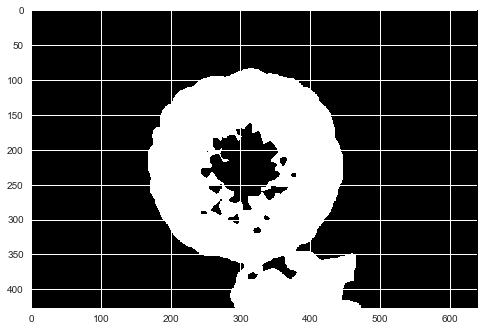

In [15]:
# This gives us a list of region sizes.
obj_sizes = ndimage.sum(binarized, labels, range(num_labels + 1))

# Now we define a threshold on the SIZE of the object.
remove_pixels = (obj_sizes < obj_sizes.max())

# Create a mask on the size, and set all the objects that fit this mask to 0.
mask_labels = remove_pixels[labels]
labels[mask_labels] = 0
plt.imshow(labels, cmap = "gray")

Hooray! We managed to use thresholding and some blurring to segment out the flower!

To tie it all back up, let's go back to the original image. We'll use the object mask for the flower to keep those pixels their own colors, but we'll set everything else to be black.

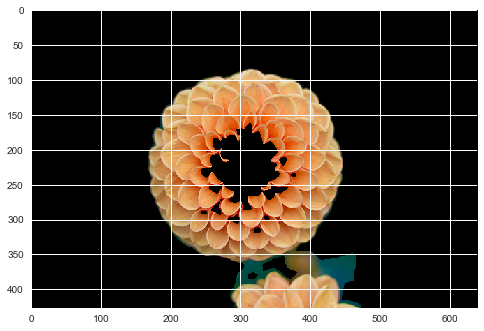

In [16]:
# Our original RGB image is in the variable "img"
img_nobackground = np.copy(img)
img_nobackground[labels == 0, :] = 0  # "labels" is 2D, but "img" is 3D, so that third dimension is covered with ":"
plt.imshow(img_nobackground)

Not too shabby! :)

Obviously it's not perfect--we're missing the fine details of the very center of the flower, and there's a little bit of noise that got through between the central flower and the few petals of the one sticking up into the bottom of the picture. But using this very limited set of tools, we did a pretty good job!

## Part 3: Computer Vision in Python

There is an entire ecosystem of computer vision packages for Python. Some are very general (a lot like `ndimage`) while some are very specific to certain classes of problems. You could spend an entire career with just one or two of these packages, but very briefly I'll name a few of the most popular. I highly encourage you to check some of these out.

### `scikit-image`

![scikitimage](Lecture19/logo.png)

If `scipy.ndimage` proves to be insufficient for your needs, this should be the first stop you take in looking for alternatives. It has a wealth of general-purpose image processing routines built-in. It's actively developed and very easy to use.

http://scikit-image.org/

### `mahotas`

Another excellent general-purpose image processing library, though it has a slight preference for bio-imaging applications. After all, its author is a computational biologist!

Like `scikit-image`, it's actively developed, easy to use, and integrates fully with the NumPy + SciPy scientific computing environment for Python.

http://mahotas.readthedocs.io/en/latest/

### OpenCV

![opencv](Lecture19/logoweblarge640_480.png)

OpenCV (for "Open Computer Vision") is the Grand Daddy of image processing packages. You'll want to use this if computer vision is a significant part of your day-to-day career. It's not for the faint of heart, however: it's a C++ library with Python bindings, which means you have to install from source, and that can be painful depending on how (un)comfortable you are with compiling things from scratch.

That said, OpenCV has everything: automated image segmentation and facial recognition, video stabilization, optical flow algorithms, stitching, filtering, warping, matching...the list goes on and on. It's well-maintained, well-documented, and while it can be a little tricky to use, it has a huge community of developers and users ready to help.

http://opencv.org/

## Review Questions

Some questions to discuss and consider:

1: An image can basically be considered conceptually to be a two-dimensional histogram, where each pixel is a "bin" and the pixel's value is the bin height. Increases in photo resolution equate to shrinking bin sizes, therefore packing more bins (aka pixels) into the same two-dimensional area. As the number of bins (pixels) approaches infinity, what happens to the values of all the bins? Is it therefore possible to have a camera that takes "infinite resolution" images?

2: We used the green channel of the flower image to segment out the flower from the background. Looking back at the three separate channels, would a different channel have yielded better segmentation results (particularly in the middle of the flower)? Why or why not?

3: What do you think the "sigma" argument to the `gaussian_filter` function does?

4: Consider two pixels, $p_i$ and $p_j$, adjacent to each other. What happens to the values of $p_i$ and $p_j$ when the image is blurred? What happens to the values of $p_i$ and $p_j$ when the image is sharpened?

5: When we looked at the green channel's histogram, we noted that there seemed to be two peaks in the graph--one around 50, the other around 150. What do you think these peaks correspond to? Is there some image processing that would benefit from this information?

## Course Administrivia

 - **Assignment 9 came out yesterday, and Assignment 10 will be out tomorrow!**. The final assignments of the course!

 - **Friday's lecture and next Monday's are the only lectures remaining!**

 - **Final exam will be FRIDAY, JULY 28.** More details to come!

 - **Final exam review session (like the midterm review session) will be WEDNESDAY, JULY 26 from 10am-12pm.**

## Additional Resources

 1. Richert, Willi and Pedro Coelho, Luis. *Building Machine Learning Systems with Python*. Chapter 10. 2013. ISBN-13: 978-1782161400
 2. SciPy `ndimage` main doc page: http://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html
 3. SciPy lectures: *Image Manipulation and Processing using NumPy and SciPy* http://www.scipy-lectures.org/advanced/image_processing/